**Necessary Imports**

In [1]:
import torch
import torchvision
print(f"Torch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}\n")

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

%load_ext autoreload
%autoreload 2
%matplotlib inline

Torch version: 1.4.0
Torchvision version: 0.5.0



**Training a classifier with PyTorch**

Steps:

a) Dataloading

b) Define nn

c) Define loss & optimizer

d) Train

e) Test

**Dataloader**

In [2]:
#compose transform to be applied on dataset
#.ToTensor converts img to numpy.ndarray
#mean and std are in tuple format
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

root_path = os.path.join(os.getcwd(), 'datasets')

fashion_mnist_train = torchvision.datasets.FashionMNIST(root=root_path, train=True,
                                                          download=True, transform=transform)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root=root_path, train=False,
                                                          download=True, transform=transform)

batch_size = 8
fashion_mnist_train_dataloader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle= True)
fashion_mnist_test_dataloader = DataLoader(fashion_mnist_test, batch_size=batch_size)

#classes in fashion-mnist dataset
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [3]:
for i, batch in enumerate(fashion_mnist_train_dataloader):
    print('batch number {}'.format(i))
    images, labels = batch
    print(f"Type of input: {type(images)}")
    print(f"Shape of the input: {images.shape}")
    print(f"label: {labels}")
    break

batch number 0
Type of input: <class 'torch.Tensor'>
Shape of the input: torch.Size([8, 1, 28, 28])
label: tensor([3, 3, 8, 0, 1, 0, 6, 8])


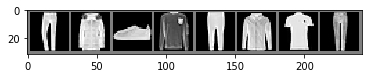

label 0: Trouser
label 1: Coat
label 2: Sneaker
label 3: Pullover
label 4: Trouser
label 5: Coat
label 6: T-shirt/top
label 7: Trouser


In [4]:
def imageshow(image):
    image = image * 0.5 + 0.5 #unnormalize w.r.t mean and std
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(fashion_mnist_train_dataloader)
images, labels = dataiter.next()

# show images in a grid
imageshow(torchvision.utils.make_grid(images))

# print labels
for i in range(batch_size):
    print("label {}: {}".format(i, classes[labels[i]]))

**Neural Network**

In [5]:
import torch.nn as nn

# 2 layer nn with sigmoid activation
class Net(nn.Module):
    def __init__(self, activation=nn.Sigmoid(), input_size=1*28*28, hidden_size=100, classes=10):
        super(Net, self).__init__()
        
        self.input_size = input_size

        # Here we initialize our activation and set up our two linear layers
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, classes)

    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten the input
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is: {}".format(device))

#  create model
net = Net()
net = net.to(device)
print(net)

# shapes of weights and biases
for parameter in net.parameters():
    print(parameter.shape)

device is: cpu
Net(
  (activation): Sigmoid()
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
torch.Size([100, 784])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


**Loss & Optimizer**

In [7]:
import torch.optim as optim

#since the problem is multiclass classification use C.E.L.
criterion = nn.CrossEntropyLoss()

#use stochastic gradient descent with momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**Train**

In [8]:
train_loss_history = [] # loss
train_acc_history = [] # accuracy

print('TRAINING.')
for epoch in range(2):
    running_loss = 0.0
    correct = 0.0
    total = 0
    
    for i, data in enumerate(fashion_mnist_train_dataloader):
        
        # get the inputs; data is a list of [inputs, labels]
        X, y = data

        X = X.to(device)
        y = y.to(device)

        # pytorch accumulates the gradients, for updating the parameters correctly zero the parameter gradients 
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X) # input x and predict based on x
        
        loss = criterion(y_pred, y) # calculate the loss
        
        loss.backward()  # backpropagation, compute gradients
        
        optimizer.step()  # apply gradients

        # loss and acc
        running_loss += loss.item()
        _, preds = torch.max(y_pred, 1) #convert output probabilities to predicted class
        correct += preds.eq(y).sum().item()
        total += y.size(0)

        # print statistics
        if i % 1000 == 999: # print every 1000 mini-batches
            running_loss /= 1000
            correct /= total
            print("[Epoch %d, Iteration %5d] loss: %.3f acc: %.2f %%" % (epoch+1, i+1, running_loss, 100*correct))
            train_loss_history.append(running_loss)
            train_acc_history.append(correct)
            running_loss = 0.0
            correct = 0.0
            total = 0

print('FINISH.')

TRAINING.
[Epoch 1, Iteration  1000] loss: 1.554 acc: 54.84 %
[Epoch 1, Iteration  2000] loss: 0.905 acc: 71.51 %
[Epoch 1, Iteration  3000] loss: 0.729 acc: 75.65 %
[Epoch 1, Iteration  4000] loss: 0.674 acc: 76.12 %
[Epoch 1, Iteration  5000] loss: 0.615 acc: 78.12 %
[Epoch 1, Iteration  6000] loss: 0.573 acc: 79.90 %
[Epoch 1, Iteration  7000] loss: 0.548 acc: 81.09 %
[Epoch 2, Iteration  1000] loss: 0.526 acc: 81.47 %
[Epoch 2, Iteration  2000] loss: 0.517 acc: 81.65 %
[Epoch 2, Iteration  3000] loss: 0.501 acc: 81.97 %
[Epoch 2, Iteration  4000] loss: 0.475 acc: 83.55 %
[Epoch 2, Iteration  5000] loss: 0.485 acc: 82.99 %
[Epoch 2, Iteration  6000] loss: 0.478 acc: 82.71 %
[Epoch 2, Iteration  7000] loss: 0.469 acc: 83.53 %
FINISH.


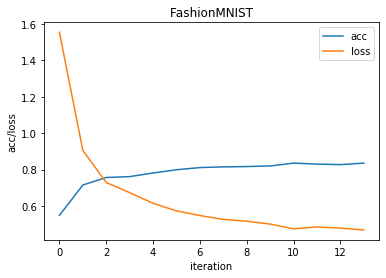

In [9]:
def plot_the_loss_acc(acc_hist, loss_hist, title):
    plt.plot(acc_hist)
    plt.plot(loss_hist)
    plt.title(title)
    plt.xlabel('iteration')
    plt.ylabel('acc/loss')
    plt.legend(['acc', 'loss'])
    plt.show()

plot_the_loss_acc(train_acc_history, train_loss_history, "FashionMNIST")

**Test**

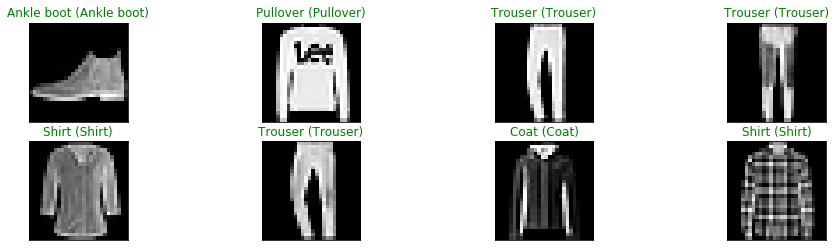

In [10]:
#obtain one batch of test images
dataiter = iter(fashion_mnist_test_dataloader)
images, labels = dataiter.next()

# get sample outputs
outputs = net(images)
# convert output probabilites to predicted class
_, predicted = torch.max(outputs, 1)

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(16,4))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[predicted[idx]], classes[labels[idx]]),
                color="green" if predicted[idx]==labels[idx] else "red")

In [11]:
# How well the performence of each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in fashion_mnist_test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %11s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top: 81 %
Accuracy of     Trouser: 93 %
Accuracy of    Pullover: 71 %
Accuracy of       Dress: 88 %
Accuracy of        Coat: 73 %
Accuracy of      Sandal: 88 %
Accuracy of       Shirt: 51 %
Accuracy of     Sneaker: 91 %
Accuracy of         Bag: 92 %
Accuracy of  Ankle boot: 91 %
